In [1]:
from core.networks.SRGAN import Generator, Discriminator

from math import log10
import json

import torch
import torch.nn as nn
import torch.optim as optim
from pytorch_msssim import ssim
from torchvision import transforms
from torchvision.transforms import functional as TF
import numpy as np
import matplotlib.pyplot as plt
from safetensors.torch import load_model, save_model
from PIL import Image

from data.get_data import get_bsds300, get_bsd100
import core.utils as U
from core.device import get_device
from core.loss import GeneratorLoss

In [2]:
model_path = "./models"
result_path = "./results"

batch_size = 10
epochs = 400
optimizer = "SGD_LRD"
generator_lr = 0.1
discriminator_lr = 0.1
upscale_factor = 4

generator_name = "SRGAN_generator"
discriminator_name = "SRGAN_discriminator"
device = get_device()

In [3]:
train_loader, val_loader = get_bsds300(upscale_factor=4, batch_size=batch_size)
test_loader = get_bsd100(4, batch_size)

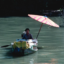

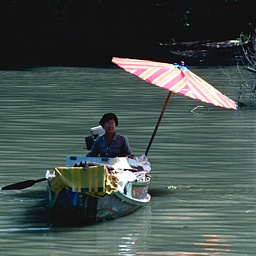

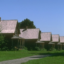

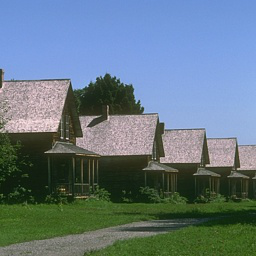

In [4]:
dateiter = iter(train_loader)
inputs, targets = next(dateiter)

for i in range(min(2, len(inputs))):
    input_image = TF.to_pil_image(inputs[i])
    target_image = TF.to_pil_image(targets[i])
    display(input_image)
    display(target_image)
    

In [5]:
generator = Generator(5)
discriminator = Discriminator()

use_pretrained_model = False

try:
    load_model(generator, f"{model_path}/{generator_name}.safetensors")
    load_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")
    use_pretrained_model = True
    print("Loaded pretrained model")
except:
    generator = nn.DataParallel(generator)
    discriminator = nn.DataParallel(discriminator)
    print("No pretrained model found")

generator.to(device)
discriminator.to(device)

print("Model loaded")

No pretrained model found
Model loaded


In [6]:
from core.optimizers.sgd_lrd import SGD_LRD
from core.scheduler import CosineAnnealingWarmupRestarts


generator_optimizer = SGD_LRD(generator.parameters(), lr=generator_lr, momentum=0.9, weight_decay=5e-4)
generator_scheduler = CosineAnnealingWarmupRestarts(optimizer, epochs/2, max_lr=generator_lr, min_lr=generator_lr/100, warmup_steps=4)

discriminator_optimizer = SGD_LRD(discriminator.parameters(), lr=discriminator_lr, momentum=0.9, weight_decay=5e-4)
discriminator_scheduler = CosineAnnealingWarmupRestarts(optimizer, epochs/2, max_lr=discriminator_lr, min_lr=discriminator_lr/100, warmup_steps=4)



generator_criterion = GeneratorLoss().to(device)

c:\Users\thinl\scoop\apps\miniconda3\current\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
loss_history = {
    "g_loss": [],
    "d_loss": [],
    "g_score": [],
    "d_score": [],
    "psnr": [],
    "ssim": []
}


if not use_pretrained_model:

    for epoch in range(1, epochs + 1):
        print(f"train epoch {epoch}")
        generator.train()
        discriminator.train()
        
        running_loss = {"g_loss": 0, "d_loss": 0, "g_score": 0, "d_score": 0}

        for i, data in enumerate(train_loader):
            inputs, targets = data[0].to(device), data[1].to(device)
            
            discriminator.zero_grad()
            
            outputs = generator(inputs)
            
            # 1. update discriminator
            d_real = discriminator(targets).mean()
            d_fake = discriminator(outputs).mean()
            
            d_loss = 1 - d_real + d_fake
            d_loss.backward(retain_graph=True)
            discriminator_optimizer.step()

            # 2. update generator
            generator.zero_grad()
            d_fake = discriminator(outputs)
            g_loss = generator_criterion(d_fake, outputs, targets)
            g_loss.backward()
            
            outputs = generator(inputs)
            d_fake = discriminator(outputs).mean()
            

            generator_optimizer.step()
            
            running_loss["g_loss"] += g_loss.cpu().item() * batch_size
            running_loss["d_loss"] += d_loss.cpu().item() * batch_size
            running_loss["g_score"] += d_real.cpu().item() * batch_size
            running_loss["d_score"] += d_fake.cpu().item() * batch_size
        
        generator_scheduler.step()
        discriminator_scheduler.step()
        
        generator.eval()

        with torch.no_grad():
            print(f"validate epoch {epoch}")
            val_results = {"mse": 0, "ssims": 0, "psnr": 0, "ssim": 0}
            
            for i, data in enumerate(val_loader):
                inputs, targets = data[0].to(device), data[1].to(device)
                outputs = generator(inputs)
                
                mse = torch.mean((outputs - targets) ** 2)
                val_results["mse"] += mse.cpu().item() * batch_size

                ssim_val = ssim(outputs, targets, data_range=1.0).cpu().item()
                val_results["ssims"] += ssim_val * batch_size
                val_results["psnr"] = 10 * log10((targets.max().cpu().item() ** 2) / val_results["mse"] / batch_size)
                val_results["ssim"] = val_results["ssims"] / batch_size
        
        loss_history['d_loss'].append(running_loss['d_loss'] / batch_size)
        loss_history['g_loss'].append(running_loss['g_loss'] / batch_size)
        loss_history['d_score'].append(running_loss['d_score'] / batch_size)
        loss_history['g_score'].append(running_loss['g_score'] / batch_size)
        loss_history['psnr'].append(val_results['psnr'])
        loss_history['ssim'].append(val_results['ssim'])

        if epoch % 10 == 0:
            print(f"Epoch {epoch} - D loss: {running_loss['d_loss'] / batch_size} - G loss: {running_loss['g_loss'] / batch_size}")
            print(f"Epoch {epoch} - D score: {running_loss['d_score'] / batch_size} - G score: {running_loss['g_score'] / batch_size}")
            print(f"Epoch {epoch} - PSNR: {val_results['psnr']} - SSIM: {val_results['ssim']}")
            print("-------------")
            
    with open(f"{result_path}/SRGAN.txt", "w", encoding="utf-8") as f:
        f.write(json.dumps(loss_history, indent=2))

    save_model(generator, f"{model_path}/{generator_name}.safetensors")
    save_model(discriminator, f"{model_path}/{discriminator_name}.safetensors")
else:
    with open(f"{result_path}/SRGAN.txt", "r", encoding="utf-8") as f:
        loss_history = json.load(f)

train epoch 1
validate epoch 1
train epoch 2
validate epoch 2
train epoch 3
validate epoch 3
train epoch 4
validate epoch 4
train epoch 5
validate epoch 5
train epoch 6
validate epoch 6
train epoch 7
validate epoch 7
train epoch 8
validate epoch 8
train epoch 9
validate epoch 9
train epoch 10
validate epoch 10
Epoch 10 - D loss: 19.36908209323883 - G loss: 0.6430165432393551
Epoch 10 - D score: 11.385309994220734 - G score: 12.199532598257065
Epoch 10 - PSNR: -14.262682836977167 - SSIM: 1.1501388624310493
-------------
train epoch 11
validate epoch 11
train epoch 12
validate epoch 12
train epoch 13
validate epoch 13
train epoch 14
validate epoch 14
train epoch 15
validate epoch 15
train epoch 16
validate epoch 16
train epoch 17
validate epoch 17
train epoch 18
validate epoch 18
train epoch 19
validate epoch 19
train epoch 20
validate epoch 20
Epoch 20 - D loss: 19.788983821868896 - G loss: 0.44088173657655716
Epoch 20 - D score: 10.579331040382385 - G score: 10.81189250946045
Epoch 20 

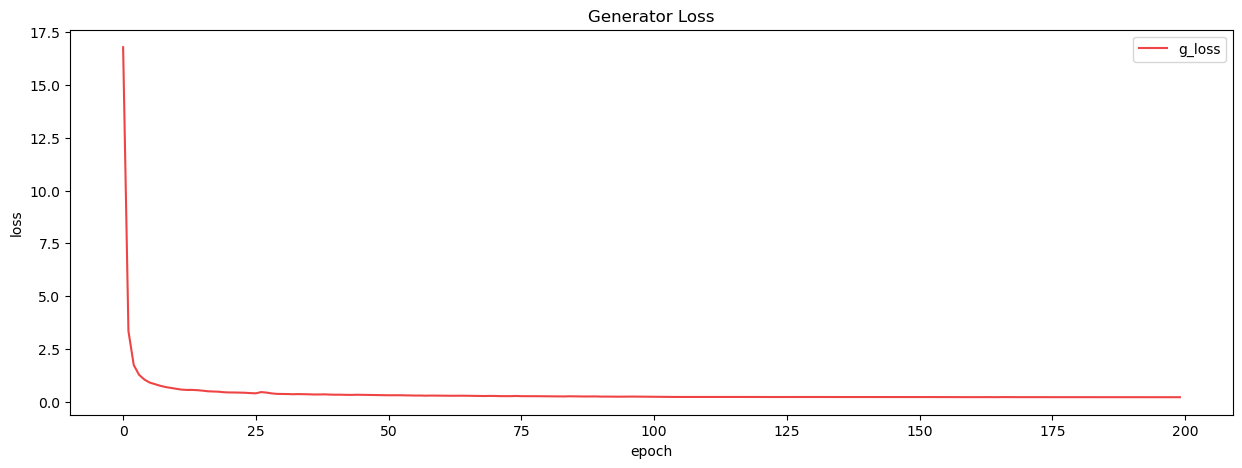

Min generator loss: 0.20462011313065886


In [11]:
X = np.arange(epochs)

fig = plt.gcf()
plt.plot(X, loss_history["g_loss"], color=U.get_color(0), label="g_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Generator Loss")
fig.set_size_inches(15, 5)
plt.show()
print(f"Min generator loss: {min(loss_history['g_loss'])}")

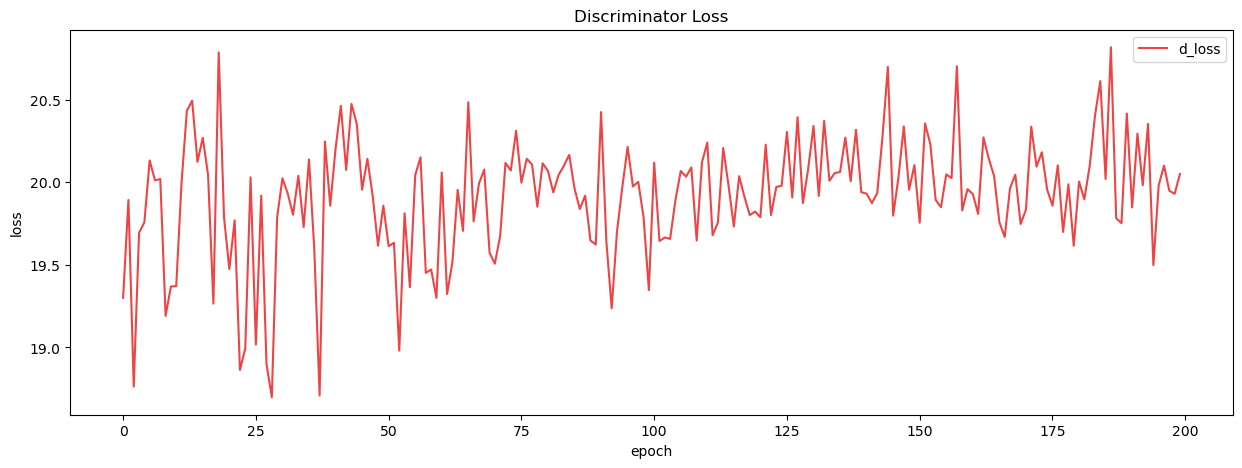

Min discriminator loss: 18.699007272720337


In [12]:
fig = plt.gcf()
plt.plot(X, loss_history["d_loss"], color=U.get_color(0), label="d_loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.title("Discriminator Loss")
fig.set_size_inches(15, 5)
plt.show()
print(f"Min discriminator loss: {min(loss_history['d_loss'])}")

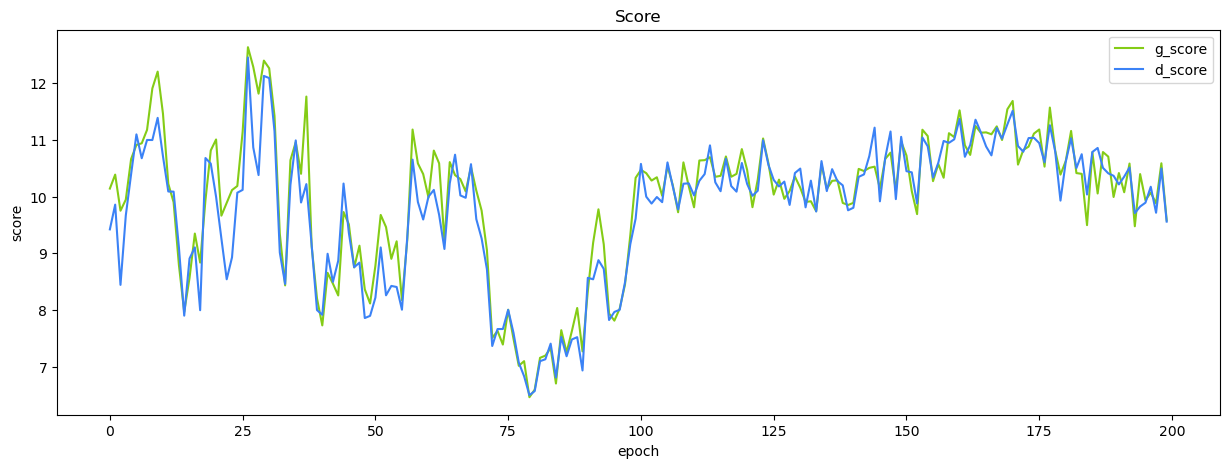

In [13]:
fig = plt.gcf()
plt.plot(X, loss_history["g_score"], color=U.get_color(4), label="g_score")
plt.plot(X, loss_history["d_score"], color=U.get_color(10), label="d_score")
plt.xlabel("epoch")
plt.ylabel("score")
plt.legend()
plt.title("Score")
fig.set_size_inches(15, 5)
plt.show()

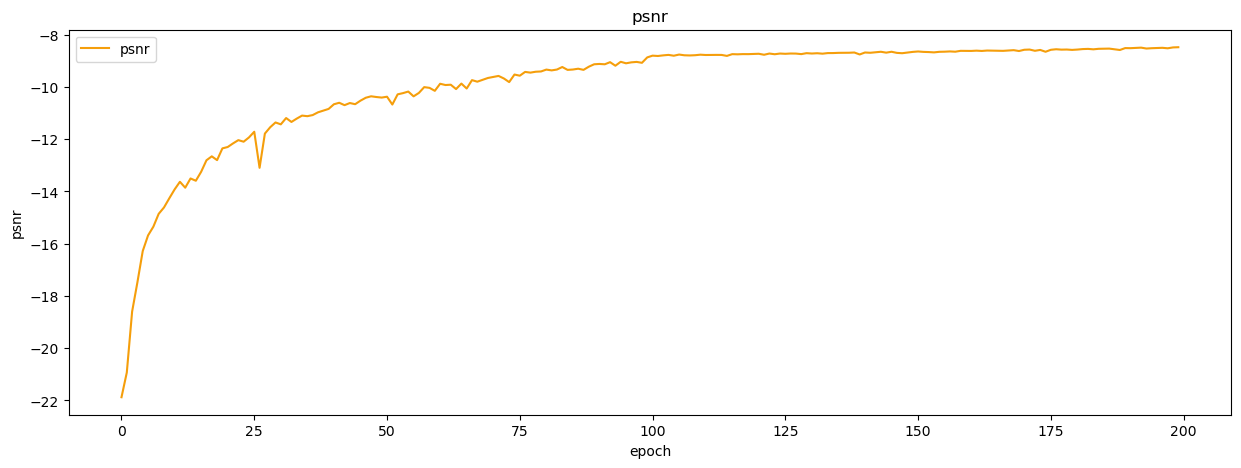

In [14]:
fig = plt.gcf()
plt.plot(X, loss_history["psnr"], color=U.get_color(2), label="psnr")
plt.xlabel("epoch")
plt.ylabel("psnr")
plt.legend()
plt.title("psnr")
fig.set_size_inches(15, 5)
plt.show()

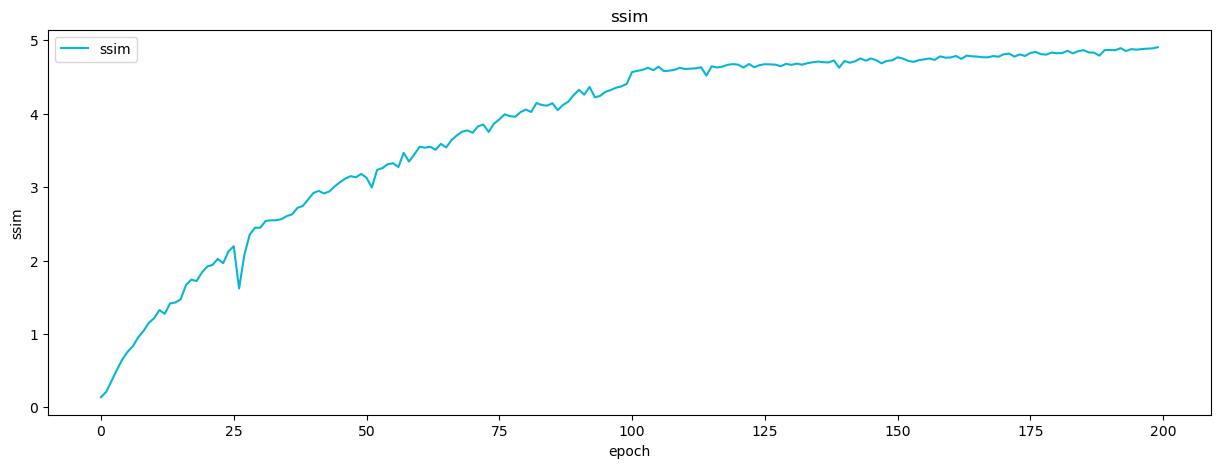

In [15]:
fig = plt.gcf()
plt.plot(X, loss_history["ssim"], color=U.get_color(8), label="ssim")
plt.xlabel("epoch")
plt.ylabel("ssim")
plt.legend()
plt.title("ssim")
fig.set_size_inches(15, 5)
plt.show()

====================Image 1====================
Low Resolution


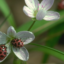

High Resolution


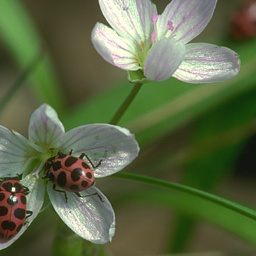

Generated Image


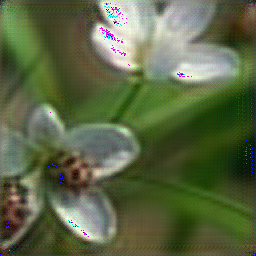

====================Image 2====================
Low Resolution


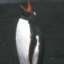

High Resolution


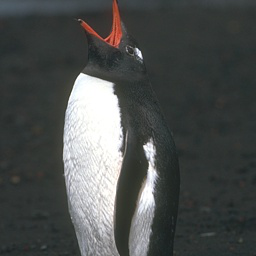

Generated Image


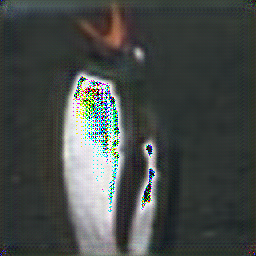

In [26]:
dateiter = iter(train_loader)
inputs, targets = next(dateiter)

for i in range(min(2, len(inputs))):
    print(f"====================Image {i+1}====================")
    input_image = TF.to_pil_image(inputs[i])
    target_image = TF.to_pil_image(targets[i])
    print("Low Resolution")
    display(input_image)
    print("High Resolution")
    display(target_image)

    generated = generator(inputs[i].unsqueeze(0))
    generated_image = TF.to_pil_image(generated.squeeze(0))
    print("Generated Image")
    display(generated_image)